In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import hdf5storage
import h5py

In [3]:
with h5py.File('hw3_data2.mat', 'r') as file:
    Xn = list(file['Xn'])
with h5py.File('hw3_data2.mat', 'r') as file:
    Yn = list(file['Yn'])    

Xn = np.array(Xn)
Yn = np.array(Yn)
Xn = Xn.T
Yn = Yn.flatten()

print(np.shape(Xn))
print(np.shape(Yn))

(1000, 100)
(1000,)


In [4]:
#Part A

def ridge_regression(X, Y, lambdaa):
    weight = np.linalg.inv(X.T.dot(X) + lambdaa*(np.identity(np.shape(X)[1]))).dot(X.T).dot(Y)
    return weight

In [5]:
def R2(Xtrain, Ytrain, Xtest, Ytest, lambdaa):
    weight = ridge_regression(Xtrain, Ytrain, lambdaa)
    prediction = Xtest.dot(weight)
    R2 = (np.corrcoef(Ytest, prediction)[0, 1]) ** 2
    return R2

In [6]:
def k_fold_cross_validation(X, Y, lambdaaK, foldNum):
    size = np.shape(X)[0]
    index  = int(size / foldNum)
    validX = np.zeros((100,np.shape(X)[1]))
    testX  = np.zeros((100,np.shape(X)[1]))
    trainX = np.zeros((800,np.shape(X)[1]))
    validY = np.zeros(100)
    testY  = np.zeros(100)
    trainY = np.zeros(800)
    
    r2_valid = []
    r2_test = []
    for i in range(foldNum):
        validStartindex = (i*index) % size 
        validEndindex   = (i+1)*index % size 
        testStartindex  = (i+1)*index % size 
        testEndindex    = (i+2)*index % size 
        trainStartindex = (i+2)*index % size 
        trainEndindex   = (i+10)*index % size 
        
        if (validEndindex == 0):
            validEndindex = 1000
        elif(testEndindex == 0):
            testEndindex = 1000
            
        validX = X[validStartindex : validEndindex][:]
        validY = Y[validStartindex : validEndindex] 
        testX  = X[testStartindex  : testEndindex][:]
        testY  = Y[testStartindex  : testEndindex]
            
        if (trainStartindex >= trainEndindex):
            trainX[0: size-trainStartindex-1 ][:]     = X[trainStartindex : -1][:]
            trainX[size - trainStartindex-1  : -1][:] = X[0: trainEndindex][:] 
            trainY[0: size-trainStartindex -1]        = Y[trainStartindex : -1]
            trainY[size - trainStartindex-1  : -1]    = Y[0: trainEndindex] 
        else:
            trainX = X[trainStartindex % size : trainEndindex % size][:] 
            trainY = Y[trainStartindex % size : trainEndindex % size] 

        for lambdaa in lambdaaK:
            r2_valid.append(R2(trainX, trainY, validX, validY, lambdaa))
            r2_test.append(R2(trainX, trainY, testX, testY, lambdaa))
        
    return r2_valid, r2_test

In [7]:
K_FOLD = 10
lambda_arr = np.logspace(0, 12, num=500, base=10)

r2_valid, r2_test = k_fold_cross_validation(Xn, Yn, lambda_arr, K_FOLD)

In [8]:
# Get the mean of r2_valid and r2_test for each lambda iteration and store them in r2_valid_final and r2_test_final, 
# so we get the mean r2 valid and test values.

r2_valid_final = np.zeros(500)
r2_test_final = np.zeros(500)

temp = 0
for i in range(500):
    for j in range(K_FOLD):
        temp += r2_valid[i + j*500]
    r2_valid_final[i] = np.mean(temp)
    temp = 0
    
temp = 0
for i in range(500):
    for j in range(K_FOLD):
        temp += r2_test[i + j*500]
    r2_test_final[i] = np.mean(temp)
    temp = 0

In [8]:
# The optimal lambda value which makes R2 max for validation data
max_r2_valid = max(r2_valid_final)
for i in range(len(r2_valid_final)):
    if (r2_valid_final[i] == max_r2_valid):
        optimal_lambda_valid_index = i
        
optimal_lambda_valid = lambda_arr[optimal_lambda_valid_index]
print("The optimal lambda value for validation data is " + str(optimal_lambda_valid))

# The optimal lambda value which makes R2 max for test data
max_r2_test = max(r2_test_final)
for i in range(len(r2_test_final)):
    if (r2_test_final[i] == max_r2_test):
        optimal_lambda_test_index = i

optimal_lambda_test = lambda_arr[optimal_lambda_test_index]
print("The optimal lambda value for test data is " + str(optimal_lambda_test))

The optimal lambda value for validation data is 395.5436244734702
The optimal lambda value for test data is 354.077390896527


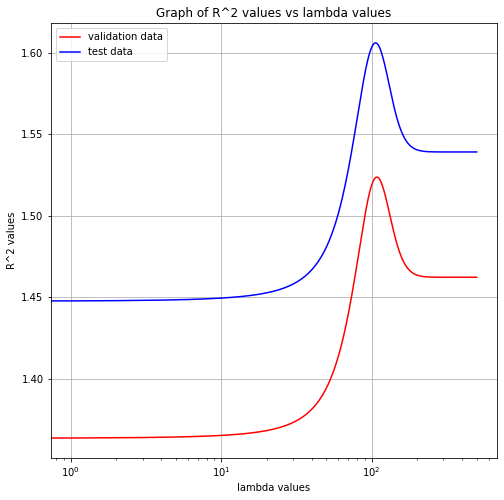

In [9]:
fig_num = 0
plt.figure(fig_num, figsize=(8,8))
t = np.logspace(0, 12, num=5000, base=10)
plt.ylabel('R^2 values')
plt.xlabel('lambda values')
plt.title('Graph of R^2 values vs lambda values')
plt.plot(r2_valid_final, color='r')
plt.plot(r2_test_final, color='b')
plt.grid()
plt.legend(['validation data', 'test data',])
plt.xscale('log')
plt.show(block=False)

In [10]:
# Part B

def bootstrap(X, Y, lambdaa, number_iterations):
    size = np.shape(X)[0]
    x_bootstrap = np.zeros((np.shape(X)[0],np.shape(X)[1]))
    y_bootstrap = np.zeros(np.shape(Y))
    weights_bootstrap = np.zeros((100,500))
    
    for i in range(number_iterations):
        for j in range(size):
            x_bootstrap = np.array(x_bootstrap)
            y_bootstrap = np.array(y_bootstrap)
            index = np.random.randint(0, 1000, size=1)
            x_bootstrap[j,:] = X[index,:]
            y_bootstrap[j] = Y[index]
        weights_bootstrap[:,i] = ridge_regression(x_bootstrap, y_bootstrap, lambdaa)
        x_bootstrap = np.zeros((np.shape(X)[0],np.shape(X)[1]))
        y_bootstrap = np.zeros(np.shape(Y))
    weights_bootstrap = np.array(weights_bootstrap)   
    weights_mean = np.mean(weights_bootstrap, axis = 1)
    weights_std = np.std(weights_bootstrap, axis = 1)
    return weights_mean, weights_std

In [11]:
weights_mean_OLS, weights_std_OLS = bootstrap(Xn, Yn, 0, 500)

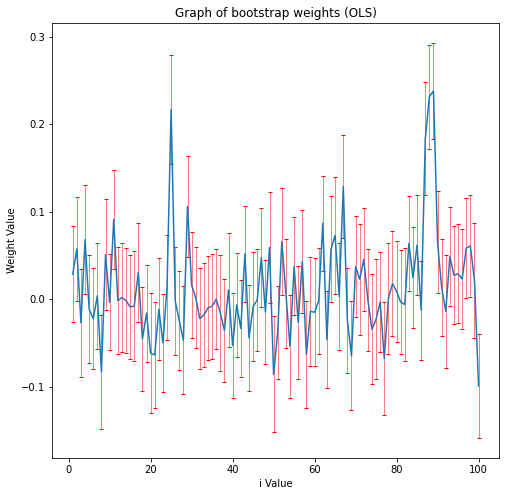

In [12]:
fig_num += 1
plt.figure(fig_num, figsize=(8,8))
plt.title('Graph of bootstrap weights (OLS)')
plt.xlabel('i Value')
plt.ylabel('Weight Value')
plt.errorbar(np.arange(1, 101), weights_mean_OLS, 2 * weights_std_OLS, ecolor='r',elinewidth=0.5, capsize=2)
plt.show(block=False)

In [13]:
# Part C

weights_mean_ridge, weights_std_ridge = bootstrap(Xn, Yn, optimal_lambda_test, 500)

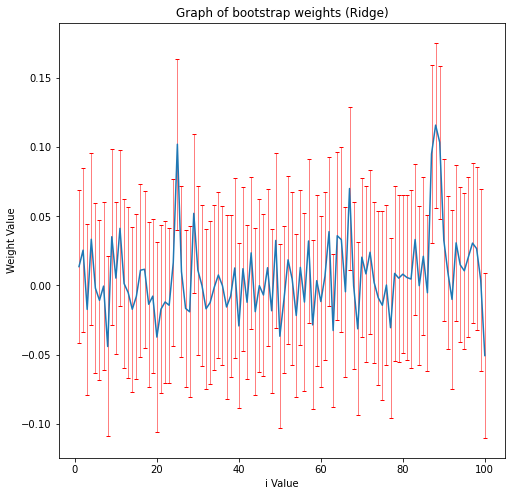

In [15]:
fig_num += 1
plt.figure(fig_num, figsize=(8,8))
plt.title('Graph of bootstrap weights (Ridge)')
plt.xlabel('i Value')
plt.ylabel('Weight Value')
plt.errorbar(np.arange(1, 101), weights_mean_ridge, 2 * weights_std_OLS, ecolor='r',elinewidth=0.5, capsize=2)
plt.show(block=False)